In [41]:
import pandas as pd

# Load data
# arena_vote_df = pd.read_parquet("arena_votes_with_scores.parquet", engine="pyarrow").drop(columns=["Unnamed: 0"])
arena_vote_df = pd.read_parquet("processed_data/arena_with_meteor.parquet", engine="pyarrow")

arena_vote_df = arena_vote_df if "Unnamed: 0" not in arena_vote_df.columns else arena_vote_df.drop(columns=["Unnamed: 0"])

In [42]:
metrics_names = [
        # "newlines",
        # "sections",
        # "lists",
        "criticism",
        "example",
        "importance_and_relevance",
        "materials_and_methods",
        "praise",
        "presentation_and_reporting",
        "results_and_discussion",
        "suggestion_and_solution",
        "meteor"
    ]

weights = {
    "bt-lr": [],
    "bt-lrvc": [],
    "abt-lr": [],
    "abt-lrs": [],
    "opt-pc": [],
    "opt-ex01": [],
    
    "bt-lr-a": [],
    "bt-lrvc-a": [],
    "abt-lr-a": [],
    "abt-lrs-a": [],
    "opt-pc-a": [],
    "opt-ex01-a": [],
    
    "bt-lr-a-lps": [],
    "bt-lrvc-a-lps": [],
    "abt-lr-a-lps": [],
    "abt-lrs-a-lps": [],
    "opt-pc-a-lps": [],
    "opt-ex01-a-lps": []
}


### Bradley-Terry

In [43]:
import pandas as pd

# arena_vote_df = pd.read_parquet("../processed_data/arena_votes_with_scores.parquet", engine="pyarrow")
arena_vote_df = pd.read_parquet("processed_data/arena_with_meteor.parquet", engine="pyarrow")

In [44]:
from typing import Literal

import numpy as np

def get_review_covariates(row, review_name:Literal['a', 'b']):
    metric_values = list()
    for metric in metrics_names:
        metric_values.append(row[f"review_{review_name}_{metric}"])
    return np.asarray(metric_values)

def translate_vote(vote_string):
    if vote_string == "👈  A is better":
        return 1
    elif vote_string == "👉  B is better":
        return -1
    elif vote_string == "🤝  Tie":
        return 0
    # elif vote_string == "👎 Both are bad":
    #     return -2
    else:
        return -10

arena_vote_df["review_a_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'a'), axis=1)
arena_vote_df["review_b_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'b'), axis=1)
arena_vote_df["covariate_diff"] = arena_vote_df["review_a_covariates"] - arena_vote_df["review_b_covariates"]
arena_vote_df["overall_quality_num"] = arena_vote_df["overall_quality"].apply(translate_vote)

In [45]:
arena_vote_has_winner = arena_vote_df[arena_vote_df["overall_quality_num"] != -10]
arena_vote_no_winner = arena_vote_df[arena_vote_df["overall_quality_num"] == -10]

In [46]:
covariate_feature_list = list()
sample_weights = list()
Y = list()

for _, row in arena_vote_has_winner.iterrows():
    if (row["overall_quality_num"] == 1):
        Y.append(1)
        covariate_feature_list.append(row["covariate_diff"])
        sample_weights.append(2)
    elif (row["overall_quality_num"] == -1):
        Y.append(0)
        covariate_feature_list.append(row["covariate_diff"])
        sample_weights.append(2)
    else:
        Y.append(1)
        covariate_feature_list.append(row["covariate_diff"])
        sample_weights.append(1)
        Y.append(0)
        covariate_feature_list.append(row["covariate_diff"])
        sample_weights.append(1)

In [47]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

X = np.stack(covariate_feature_list)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

Y = np.asarray(Y)

In [48]:
lr = LogisticRegression(fit_intercept=False, solver="saga", tol=1e-6, max_iter=100000)
lr_cv = LogisticRegressionCV(fit_intercept=False, solver="saga", penalty="elasticnet", tol=1e-6, max_iter=100000, l1_ratios=[0, 0.001, 0.01, 0.1])
lr.fit(X_scaled, Y, sample_weight=sample_weights)
lr_cv.fit(X_scaled, Y, sample_weight=sample_weights)

LogisticRegressionCV(fit_intercept=False, l1_ratios=[0, 0.001, 0.01, 0.1],
                     max_iter=100000, penalty='elasticnet', solver='saga',
                     tol=1e-06)

In [49]:
# lr.predict(X[0])


print(lr.coef_)
print(lr.classes_)
print(lr.predict(X[:1, :]), X[:1, :])

[[-0.19812713 -0.74465404 -0.1355536   0.21755429 -0.10578541  0.04973536
  -0.05049276  0.54060493  1.21248702]]
[0 1]
[1] [[-0.01724138 -0.03448276 -0.06671664 -0.11844078  0.04647676  0.02773613
   0.16641679  0.12368816 -0.05353234]]


In [50]:
print("LR")
for m, v in zip(metrics_names, lr.coef_[0]):
    print(f"{m} : {v}")
    
weights["bt-lr"] = lr.coef_[0]
    
print("\nLRCV")
for m, v in zip(metrics_names, lr_cv.coef_[0]):
    print(f"{m} : {v}")
    
weights["bt-lrvc"] = lr_cv.coef_[0]

LR
criticism : -0.1981271281986305
example : -0.744654035337708
importance_and_relevance : -0.13555360492856797
materials_and_methods : 0.21755428893411818
praise : -0.10578540890461545
presentation_and_reporting : 0.049735363407778954
results_and_discussion : -0.05049275973764363
suggestion_and_solution : 0.5406049316715683
meteor : 1.2124870226609554

LRCV
criticism : -0.043973685799266284
example : -0.003912703686822339
importance_and_relevance : 0.02294543621789909
materials_and_methods : 0.0
praise : 0.0
presentation_and_reporting : 0.0
results_and_discussion : 0.0
suggestion_and_solution : 0.0
meteor : 0.21671163682135858


### Adapted Bradley-Terry

In [104]:
from typing import Literal

import numpy as np

def get_review_covariates(row, review_name:Literal['a', 'b']):
    
    metric_values = list()
    for metric in metrics_names:
        metric_values.append(row[f"review_{review_name}_{metric}"])
    return np.asarray(metric_values)

def translate_vote(vote_string):
    if vote_string == "👈  A is better":
        return 1
    elif vote_string == "👉  B is better":
        return -1
    elif vote_string == "🤝  Tie":
        return 0
    # elif vote_string == "👎 Both are bad":
    #     return -2
    else:
        return -10
    
arena_vote_df["review_a_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'a'), axis=1)
arena_vote_df["review_b_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'b'), axis=1)
arena_vote_df["covariate_diff"] = arena_vote_df["review_a_covariates"] - arena_vote_df["review_b_covariates"]
arena_vote_df["overall_quality_num"] = arena_vote_df["overall_quality"].apply(translate_vote)

arena_vote_with_winner_df = arena_vote_df[arena_vote_df["overall_quality_num"] != -10]

In [106]:
from sklearn.linear_model import LinearRegression

X = np.stack(arena_vote_with_winner_df["covariate_diff"])
Y = np.asarray(arena_vote_with_winner_df["overall_quality_num"])

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Initialize the linear regression model
model = LinearRegression(fit_intercept=False, positive=True)

# Cross-validation R² scores
scores = cross_val_score(model, X, Y, cv=5, scoring='r2')
print("Cross-validation R² scores:", scores)
print("Std R² scores:", np.std(scores))
print("Average R²:", scores.mean())

# Fit model on full data
model.fit(X, Y)

# Coefficients
print("Final coefficients:", model.coef_)

Cross-validation R² scores: [ 0.497039    0.180244    0.31170063  0.17180723 -0.14811038]
Std R² scores: 0.21120748460930514
Average R²: 0.20253609882804485
Final coefficients: [ 0.          0.          0.2268435   0.          0.          0.
  0.          0.33447529 19.0893914 ]


label : count
   -1 :    47
    1 :    57
    0 :    29


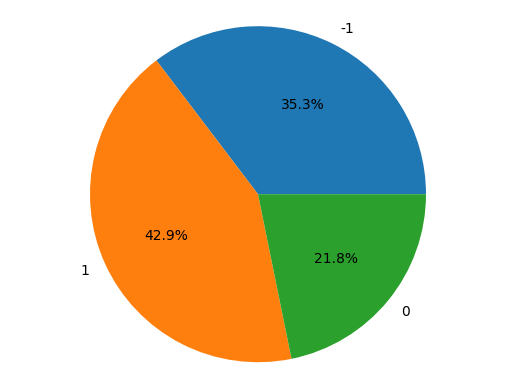

In [54]:
import matplotlib.pyplot as plt

def label_distribution(labels):
    """
    """
    label_counts = dict()
    for label in labels:
        if(label in label_counts):
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    print("label : count")
    for label, count in label_counts.items():
        print("{:5d} : {:5d}".format(label, count))
        
    labels = label_counts.keys()
    sizes = label_counts.values()
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis("equal")
    plt.show()

label_distribution(Y)

In [55]:
linear_regression = LinearRegression(fit_intercept=False, positive=True)
linear_regression.fit(X, Y)

LinearRegression(fit_intercept=False, positive=True)

In [56]:
for m, c in zip(metrics_names, linear_regression.coef_):
    print(f"{m} : {c}")
    
weights["abt-lr"] = linear_regression.coef_

criticism : 0.0
example : 0.0
importance_and_relevance : 0.22684349745296856
materials_and_methods : 0.0
praise : 0.0
presentation_and_reporting : 0.0
results_and_discussion : 0.0
suggestion_and_solution : 0.33447528651078634
meteor : 19.08939139702699


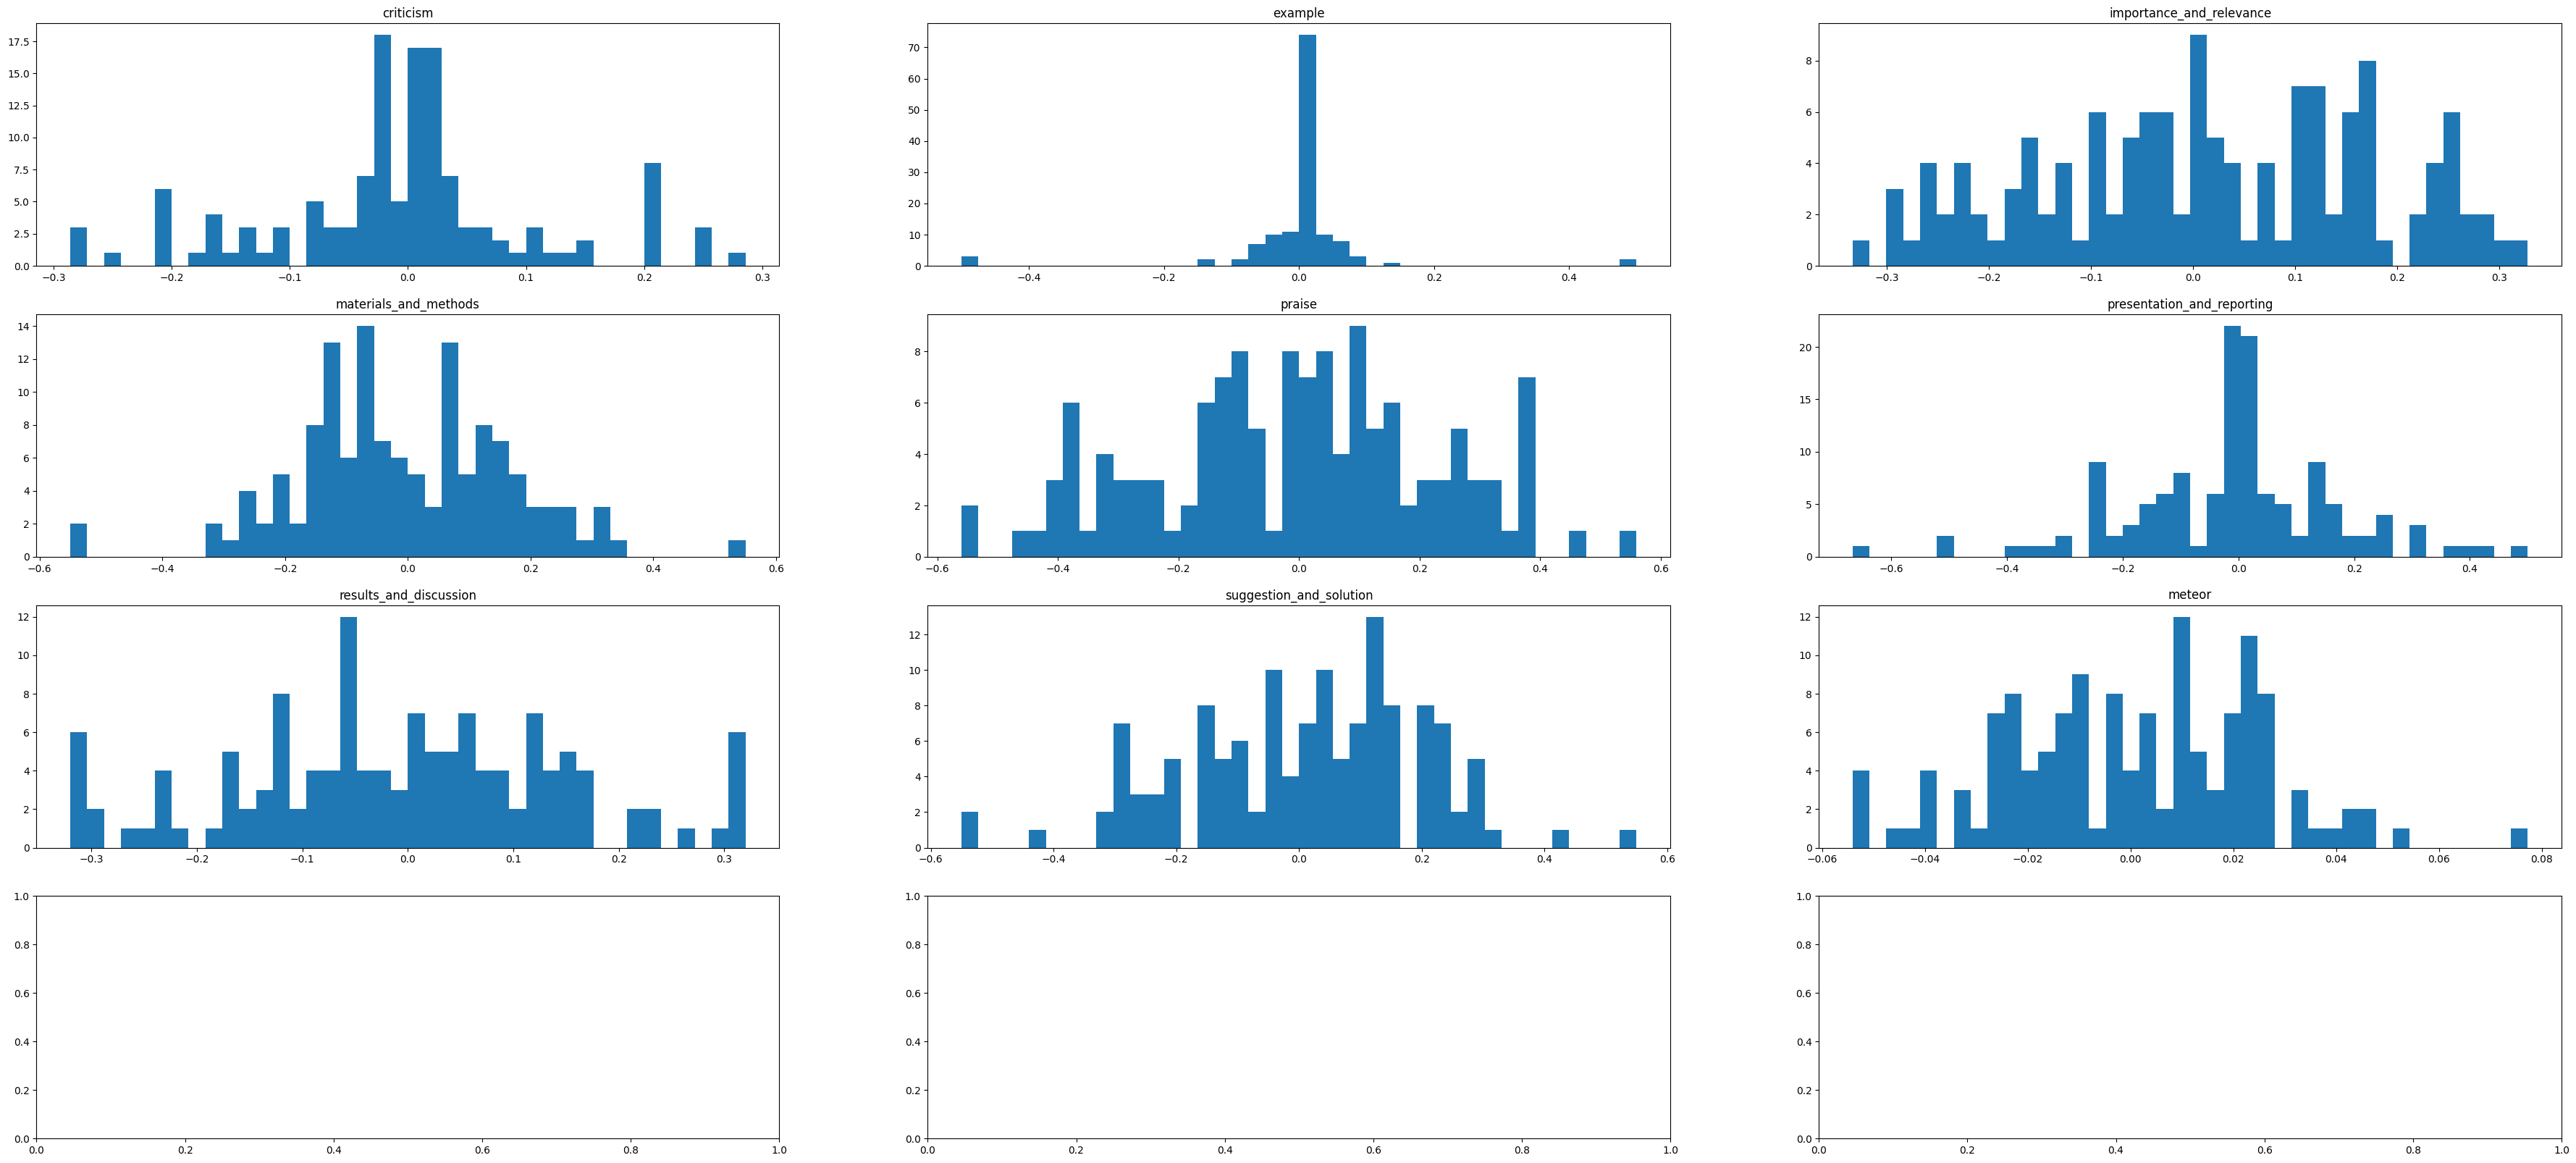

In [57]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(45, 20))

for i, m in enumerate(metrics_names):
    row = int(i / 3)
    col = i % 3
    vals = X[:, i : i+1].flatten()
    ax[row][col].hist(vals, bins=40)
    ax[row][col].set_title(m)

In [58]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X)

In [59]:
X_scaled = X_scaler.transform(X)

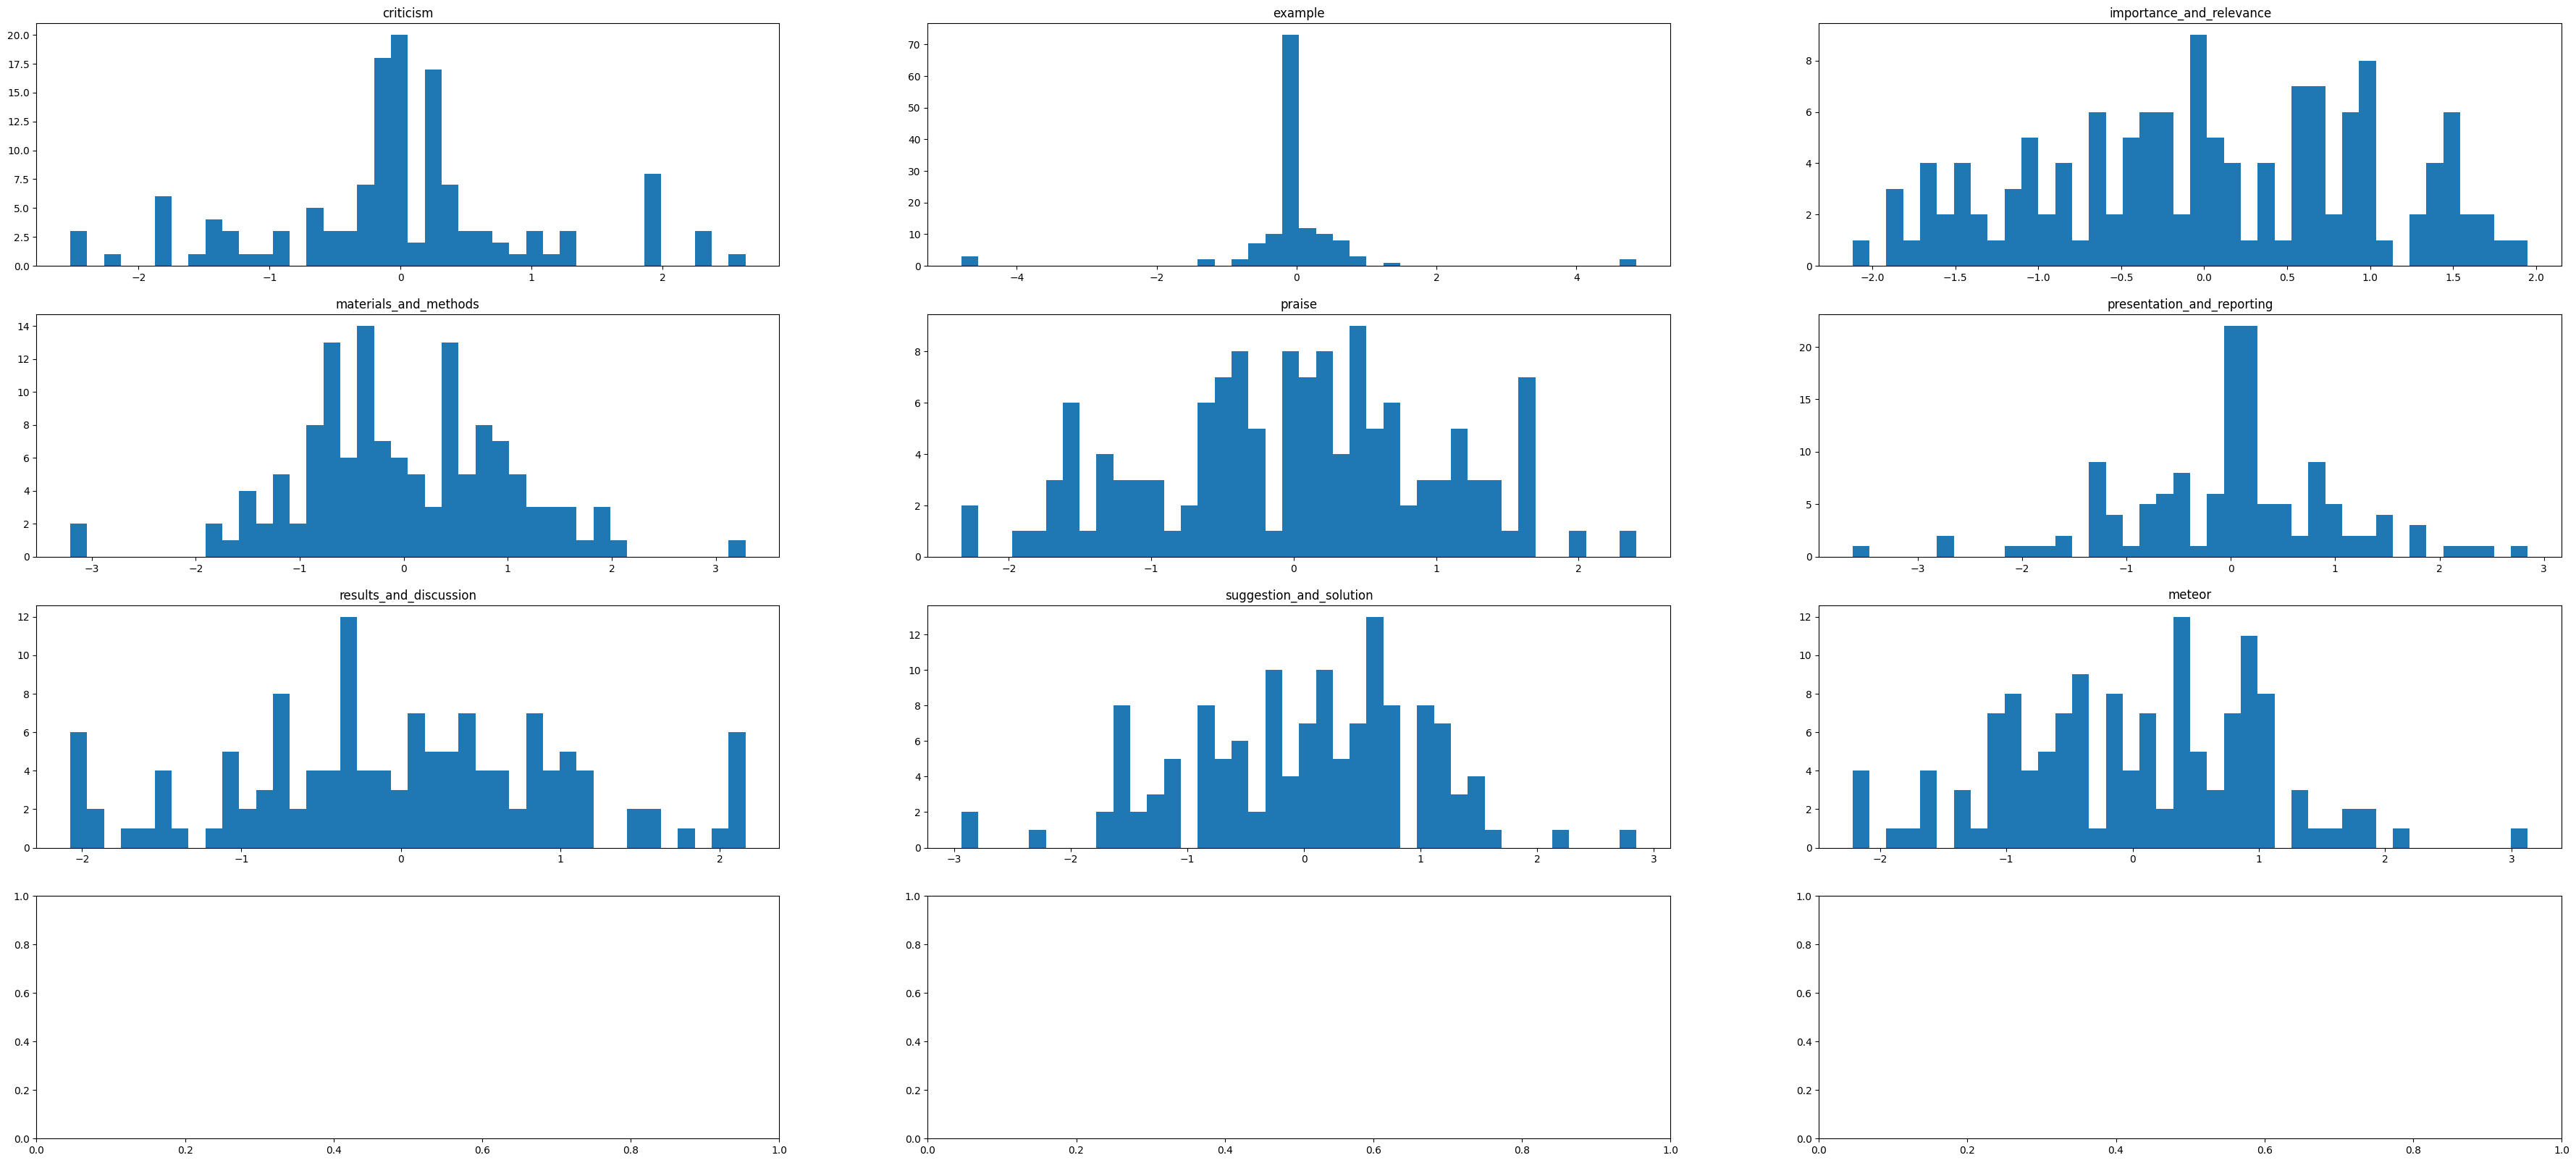

In [60]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(45, 20))

for i, m in enumerate(metrics_names):
    row = int(i / 3)
    col = i % 3
    vals = X_scaled[:, i : i+1].flatten()
    ax[row][col].hist(vals, bins=40)
    ax[row][col].set_title(m)

In [61]:
linear_regression_std_scaled = LinearRegression(fit_intercept=False, positive=True)
linear_regression_std_scaled.fit(X_scaled, Y)

LinearRegression(fit_intercept=False, positive=True)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Initialize the linear regression model
model = LinearRegression(fit_intercept=False, positive=True)

# Cross-validation R² scores
scores = cross_val_score(model, X_scaled, Y, cv=5, scoring='r2')
print("Cross-validation R² scores:", scores)
print("Std R² scores:", np.std(scores))
print("Average R²:", scores.mean())


# Fit model on full data
model.fit(X_scaled, Y)

# Coefficients
print("Final coefficients:", model.coef_)

Cross-validation R² scores: [ 0.49061868  0.17833439  0.30737758  0.16986988 -0.14977609]
Std R² scores: 0.20962210562168232
Average R²: 0.1992848869224571
Final coefficients: [0.         0.         0.03303977 0.         0.         0.
 0.         0.06182452 0.46923987]


In [62]:
for m, c in zip(metrics_names, linear_regression_std_scaled.coef_):
    print(f"{m} : {c}")
    
weights["abt-lrs"] = linear_regression_std_scaled.coef_

criticism : 0.0
example : 0.0
importance_and_relevance : 0.03303977389732074
materials_and_methods : 0.0
praise : 0.0
presentation_and_reporting : 0.0
results_and_discussion : 0.0
suggestion_and_solution : 0.061824522790195055
meteor : 0.46923986722718913


In [64]:
from sklearn.metrics import mean_squared_error

mean_squared_error(Y, linear_regression.predict(X))


0.5425718172331842

In [65]:
mean_squared_error(Y, linear_regression_std_scaled.predict(X_scaled))

0.5443171028136787

### Optimization via CVXPY

In [67]:
import pandas as pd

# Load data
arena_vote_df = pd.read_parquet("processed_data/arena_with_meteor.parquet", engine="pyarrow")

arena_vote_df = arena_vote_df if "Unnamed: 0" not in arena_vote_df.columns else arena_vote_df.drop(columns=["Unnamed: 0"])

In [68]:
from typing import Literal

import numpy as np

def get_review_covariates(row, review_name:Literal['a', 'b']):

    metric_values = list()
    for metric in metrics_names:
        metric_values.append(row[f"review_{review_name}_{metric}"])
    return np.asarray(metric_values)


def translate_vote(vote_string):
    if vote_string == "👈  A is better":
        return 1
    elif vote_string == "👉  B is better":
        return -1
    elif vote_string == "🤝  Tie":
        return 0
    # elif vote_string == "👎 Both are bad":
    #     return -2
    else:
        return -10
    

arena_vote_df["review_a_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'a'), axis=1)
arena_vote_df["review_b_covariates"] = arena_vote_df.apply(lambda row: get_review_covariates(row, 'b'), axis=1)
arena_vote_df["overall_quality_num"] = arena_vote_df["overall_quality"].apply(translate_vote)

arena_vote_with_winner_df = arena_vote_df[arena_vote_df["overall_quality_num"] != -10]

In [69]:
import cvxpy as cp

c = cp.Variable(len(metrics_names))

obj = cp.Minimize(cp.sum(c))

constraints = [
    c >= 0,
]

epsilon = 1e-12

for _, match in arena_vote_with_winner_df.iterrows():
    s_a = cp.sum(c @ match["review_a_covariates"])
    s_b = cp.sum(c @ match["review_b_covariates"])
    if (match["overall_quality_num"] == 1):
        constraints.append(s_a >= s_b + epsilon)
    elif (match["overall_quality_num"] == -1):
        constraints.append(s_a <= s_b + epsilon)
    else:
        constraints.append(s_a == s_b)
        
problem = cp.Problem(obj, constraints)
problem.solve(solver="ECOS", feastol=1e-24)
weights["opt-pc"] = c.value

/home/horton/miniconda3/envs/remorx/lib/python3.12/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [70]:
import cvxpy as cp

c_ex = cp.Variable(len(metrics_names))

obj_ex = cp.Minimize(cp.sum(c_ex))

constraints_ex = [
    c_ex >= 0,
    cp.sum(c_ex) <= 1,
    cp.sum(c_ex) >= 0,
]

epsilon = 1e-12

for _, match in arena_vote_with_winner_df.iterrows():
    s_a = cp.sum(c_ex @ match["review_a_covariates"])
    s_b = cp.sum(c_ex @ match["review_b_covariates"])
    if (match["overall_quality_num"] == 1):
        constraints_ex.append(s_a >= s_b + epsilon)
    elif (match["overall_quality_num"] == -1):
        constraints_ex.append(s_a <= s_b + epsilon)
    else:
        constraints_ex.append(s_a == s_b)
        
problem_ex = cp.Problem(obj_ex, constraints_ex)
problem_ex.solve(solver="ECOS", feastol=1e-24)
weights["opt-ex01"] = c_ex.value

In [71]:
sum([4.45656146e-24, -4.62546709e-24, -3.80324558e-24,  1.02072317e-24,
         4.02110248e-24, -2.82098919e-24, -3.56656975e-24,  6.15179447e-24,
        -8.33909976e-25])

-6.00000032612436e-33

In [72]:
weights

{'bt-lr': array([-0.19812713, -0.74465404, -0.1355536 ,  0.21755429, -0.10578541,
         0.04973536, -0.05049276,  0.54060493,  1.21248702]),
 'bt-lrvc': array([-0.04397369, -0.0039127 ,  0.02294544,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.21671164]),
 'abt-lr': array([ 0.        ,  0.        ,  0.2268435 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.33447529, 19.0893914 ]),
 'abt-lrs': array([0.        , 0.        , 0.03303977, 0.        , 0.        ,
        0.        , 0.        , 0.06182452, 0.46923987]),
 'opt-pc': array([ 7.72141737e-12,  4.80267398e-12,  2.41855082e-12, -5.01682536e-13,
         6.38875720e-13, -2.48641227e-12,  2.29551792e-12,  2.07566488e-12,
         2.31208089e-11]),
 'opt-ex01': array([ 4.97337064e-12,  3.41016625e-12,  1.89937329e-12, -4.31591717e-13,
         4.42405358e-13, -1.77915639e-12,  1.17477965e-12,  1.53984425e-12,
         1.54735650e-11]),
 'bt-lr-a': [],
 'bt-lrvc-a': [],
 'abt-lr-a': [

In [73]:
import numpy as np

def scale_greater_than_1(test_weights):
    # Scale all weights until maximum is greater than 1
    max_weight = np.max(test_weights)
    modifier = 1

    while (max_weight * modifier < 1):
        modifier *= 10
        
    updated_weights = np.asarray([modifier * w for w in test_weights])
    return updated_weights

def scale_weights(test_weights, target_sum=9):
    
    updated_weights = scale_greater_than_1(test_weights)
    min_weight = np.min(updated_weights)
    positive_weights = updated_weights - min_weight
    current_sum = np.sum(positive_weights)
    final_weights = np.asarray([w * target_sum / current_sum for w in positive_weights])

    return final_weights

test_weights = weights["opt-pc"]

for alg, vals in weights.items():
    if(alg.endswith("-a") or alg.endswith("-lps")):
        continue
    weights[f"{alg}-a"] = scale_weights(vals)

weights["opt-pc"] = scale_greater_than_1(weights["opt-pc"])
weights["opt-ex01"] = scale_greater_than_1(weights["opt-ex01"])

def apply_laplace_smoothing(target_weights: np.ndarray):
    target_sum = 9
    laplace_addition = 1e-2
    new_weights = np.asarray([w + laplace_addition for w in target_weights])
    new_weights = np.asarray([w * target_sum / np.sum(new_weights) for w in new_weights])

    return new_weights

for name, w in weights.items():
    if(name.endswith("-a")):
        new_weights = apply_laplace_smoothing(w)
        weights[f"{name}-lps"] = new_weights

weights

{'bt-lr': array([-0.19812713, -0.74465404, -0.1355536 ,  0.21755429, -0.10578541,
         0.04973536, -0.05049276,  0.54060493,  1.21248702]),
 'bt-lrvc': array([-0.04397369, -0.0039127 ,  0.02294544,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.21671164]),
 'abt-lr': array([ 0.        ,  0.        ,  0.2268435 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.33447529, 19.0893914 ]),
 'abt-lrs': array([0.        , 0.        , 0.03303977, 0.        , 0.        ,
        0.        , 0.        , 0.06182452, 0.46923987]),
 'opt-pc': array([ 0.77214174,  0.4802674 ,  0.24185508, -0.05016825,  0.06388757,
        -0.24864123,  0.22955179,  0.20756649,  2.31208089]),
 'opt-ex01': array([ 0.49733706,  0.34101663,  0.18993733, -0.04315917,  0.04424054,
        -0.17791564,  0.11747797,  0.15398443,  1.5473565 ]),
 'bt-lr-a': array([0.65691357, 0.        , 0.7321256 , 1.15655368, 0.76790633,
        0.95483894, 0.8343669 , 1.54485359, 2.35244139]),

### Model Comparison

In [74]:
# weights = {
#     "bt-lr": [-0.198127733297757, -0.744657840793651, -0.135553179028411, 0.217553088733012, -0.105786174031378, 0.0497352489015174, -0.0504924465145714, 0.540603950418466, 1.21248696074333],
#     "bt-lrvc": [-0.0439735762152414, -0.00391283773294049, 0.022945434865521, 0, 0, 0 ,0, 0, 0.216711547102243],
#     "abt-lr": [0, 0, 0.226843497452968, 0, 0, 0, 0, 0.334475286510786, 19.0893913970269],
#     "abt-lrs": [0, 0, 0.0330397738973207, 0, 0, 0, 0, 0.061824522790195, 0.469239867227189],
#     "opt-pc": [-0.582660589, 0.122372172, 0.237513906, 0.0437739993, -0.144758823, -0.013683791, 0.0793118243, 0.113870237, 1.14410124],
#     "opt-ex01": [0.171931785, 0.0985797109, 0.047472539, -0.00386124143, 0.00690784644, -0.0493220187, 0.0813698175, 0.045223288, 0.623014459],
    
#     "bt-lr-a": [0.656915007465194,0,0.732127997968719,1.15655256916994,0.76790716556012,0.954839880346978,0.834368791235069,1.54485132216651,2.35243726608747],
#     "bt-lrvc-a": [0,0.613662206766512,1.02508514745919,0.673600209132005,0.673600209132005,0.673600209132005,0.673600209132005,0.673600209132005,3.99325160011428],
#     "abt-lr-a": [0,0,0.103894030204143,0,0,0,0,0.153189251221521,8.74291671857434],
#     "abt-lrs-a": [0,0,0.527133079487157,0,0,0,0,0.986379361659682,7.48648755885316],
#     "opt-pc-a": [0,1.0162576649663,1.18222678896706,0.902963645344535,0.63120616631853,0.820142075859481,0.95418904797867,1.00400269315685,2.48901191740858],
#     "opt-ex01-a": [1.35903953428401,0.908478382536317,0.59455534059971,0.279240368011852,0.345388908370294,0,0.802767542224045,0.580739437865344,4.12979048610842]
# }




In [75]:
# weight_name = "bt-lr"

def get_score_match_result(cov_a, cov_b, weight_name):
    selected_weight = weights.get(weight_name)

    score_a = cov_a @ selected_weight
    score_b = cov_b @ selected_weight

    if score_a > score_b:
        # print("A is better than B")
        return 1
    elif score_a < score_b:
        # print("B is better than A")
        return -1
    else:
        # print("A is equal to B")
        return 0
        
# get_score_match_result(match["review_a_covariates"], match["review_b_covariates"], weight_name)

In [76]:
arena_vote_analyze = arena_vote_with_winner_df.copy()

for weight_name in weights:
    arena_vote_analyze[f"result_{weight_name}"] = arena_vote_analyze.apply(lambda row: get_score_match_result(row["review_a_covariates"], row["review_b_covariates"], weight_name), axis=1)

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

alg_performance = dict()

for weight_name in weights:
    acc = accuracy_score(arena_vote_analyze["overall_quality_num"], arena_vote_analyze[f"result_{weight_name}"])
    f1 = f1_score(arena_vote_analyze["overall_quality_num"], arena_vote_analyze[f"result_{weight_name}"], average="weighted")
    print(f"Metrics for {weight_name}")
    print("Accuracy: {}".format(acc))
    print("F1: {}".format(f1))
    print()
    alg_performance[weight_name] = {
        "acc": acc,
        "f1": f1,
    }
    # print(classification_report(arena_vote_analyze["overall_quality_num"], arena_vote_analyze[f"result_{weight_name}"]))

Metrics for bt-lr
Accuracy: 0.5639097744360902
F1: 0.49461641115776456

Metrics for bt-lrvc
Accuracy: 0.6090225563909775
F1: 0.5353441518855053

Metrics for abt-lr
Accuracy: 0.631578947368421
F1: 0.5553168635875403

Metrics for abt-lrs
Accuracy: 0.5789473684210527
F1: 0.5086181623784232

Metrics for opt-pc
Accuracy: 0.5413533834586466
F1: 0.476219119226638

Metrics for opt-ex01
Accuracy: 0.5338345864661654
F1: 0.46949419881750704

Metrics for bt-lr-a
Accuracy: 0.47368421052631576
F1: 0.41677278378480204

Metrics for bt-lrvc-a
Accuracy: 0.518796992481203
F1: 0.4559717116700125

Metrics for abt-lr-a
Accuracy: 0.631578947368421
F1: 0.5553168635875403

Metrics for abt-lrs-a
Accuracy: 0.5789473684210527
F1: 0.5086181623784232

Metrics for opt-pc-a
Accuracy: 0.5037593984962406
F1: 0.4427974015209821

Metrics for opt-ex01-a
Accuracy: 0.49624060150375937
F1: 0.43635149650187244

Metrics for bt-lr-a-lps
Accuracy: 0.47368421052631576
F1: 0.41677278378480204

Metrics for bt-lrvc-a-lps
Accuracy: 0

In [78]:
for name, weight_val in weights.items():
    print(f"{name}")
    acc = alg_performance[name]["acc"]
    f1 = alg_performance[name]["f1"]
    for val in weight_val:
        if("lrvc" in name or "lrs" in name):
            # print("\multirow\{2\}\{*\}\{{}\}".format(0))
            print(f"\\multirow{{2}}{{*}}{{{val:.2f}}}", end=" & ")
        else:
            print(f"{val:.2f}", end=" & ")    
    if("lrvc" in name or "lrs" in name):
        print(f"\\multirow{{2}}{{*}}{{{acc:.2f}}} & \\multirow{{2}}{{*}}{{{f1:.2f}}}")
    else: 
        print(f"{acc:.2f} & {f1:.2f}")

bt-lr
-0.20 & -0.74 & -0.14 & 0.22 & -0.11 & 0.05 & -0.05 & 0.54 & 1.21 & 0.56 & 0.49
bt-lrvc
\multirow{2}{*}{-0.04} & \multirow{2}{*}{-0.00} & \multirow{2}{*}{0.02} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.22} & \multirow{2}{*}{0.61} & \multirow{2}{*}{0.54}
abt-lr
0.00 & 0.00 & 0.23 & 0.00 & 0.00 & 0.00 & 0.00 & 0.33 & 19.09 & 0.63 & 0.56
abt-lrs
\multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.03} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.00} & \multirow{2}{*}{0.06} & \multirow{2}{*}{0.47} & \multirow{2}{*}{0.58} & \multirow{2}{*}{0.51}
opt-pc
0.77 & 0.48 & 0.24 & -0.05 & 0.06 & -0.25 & 0.23 & 0.21 & 2.31 & 0.54 & 0.48
opt-ex01
0.50 & 0.34 & 0.19 & -0.04 & 0.04 & -0.18 & 0.12 & 0.15 & 1.55 & 0.53 & 0.47
bt-lr-a
0.66 & 0.00 & 0.73 & 1.16 & 0.77 & 0.95 & 0.83 & 1.54 & 2.35 & 0.47 & 0.42
bt-lrvc-a
\multirow{2}{*}{0.00} & \m

In [79]:
pd.DataFrame([{
    "name": name,
    "acc": val["acc"],
    "f1": val["f1"]
} for name, val in alg_performance.items()])

,name,acc,f1
0,bt-lr,0.563910,0.494616
1,bt-lrvc,0.609023,0.535344
2,abt-lr,0.631579,0.555317
3,abt-lrs,0.578947,0.508618
4,opt-pc,0.541353,0.476219
5,opt-ex01,0.533835,0.469494
6,bt-lr-a,0.473684,0.416773
7,bt-lrvc-a,0.518797,0.455972
8,abt-lr-a,0.631579,0.555317
9,abt-lrs-a,0.578947,0.508618
